In [1]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
mp.rcParams['axes.linewidth'] = 1
font_legend = 15; font_axes=15
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

In [2]:
FONTSIZE=18
font = {'family': 'serif', 'weight':'normal', 'size':FONTSIZE}
mp.rc('font', **font)
mp.rc('text',usetex=True)

In [3]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
SIR_data = pd.read_csv('../../data/SIR_data.csv.gz')
SIR_data

,alpha,beta,I,li
0,0.556824,0.432547,"[3.0000e+00,2.5413e+01,6.6242e+01,1.4076e+02,2...","[3.5465e-02,6.0205e-02,5.2629e-02,1.9994e-02,3..."
1,0.917183,0.617733,"[3.0000e+00,4.6435e+01,1.2668e+02,1.8865e+02,1...","[4.6994e-02,6.1737e-02,5.9416e-02,6.5321e-02,3..."
2,0.222595,0.684092,"[3.0000e+00,2.3207e+02,5.2139e+02,5.1127e+02,4...","[3.8465e-02,1.4980e-02,4.3391e-02,8.0108e-02,6..."
3,0.513685,0.231400,"[3.0000e+00,6.2250e+00,8.8920e+00,1.2593e+01,1...","[1.2181e-01,1.2303e-01,6.9494e-02,8.3929e-02,6..."
4,0.533168,0.343659,"[3.0000e+00,1.3872e+01,2.8699e+01,5.5722e+01,9...","[2.9563e-02,5.4805e-02,2.3345e-02,1.7169e-01,5..."
...,...,...,...,...
245,0.018504,0.236397,"[3.0000e+00,1.7329e+01,4.0684e+01,9.1622e+01,1...","[3.5029e-02,7.6161e-02,9.8830e-02,2.7422e-02,1..."
246,0.183638,0.371210,"[3.0000e+00,3.3838e+01,1.0217e+02,2.4462e+02,4...","[5.3251e-02,9.8350e-02,3.7443e-02,2.2209e-02,1..."
247,0.097239,0.421748,"[3.0000e+00,5.7375e+01,2.0121e+02,4.4055e+02,5...","[2.2518e-02,4.6346e-02,2.5197e-02,5.0298e-02,4..."
248,0.790416,0.309533,"[3.0000e+00,6.4540e+00,9.3210e+00,1.3244e+01,1...","[6.6862e-02,4.2194e-02,5.7831e-02,3.8413e-02,3..."


In [5]:
print('alpha in [%.2f, %.2f]' % (SIR_data['alpha'].min(), SIR_data['alpha'].max()))
print('beta in [%.2f, %.2f]' % (SIR_data['beta'].min(), SIR_data['beta'].max()))

alpha in [0.00, 1.00]
beta in [0.20, 0.70]


In [6]:
def cdf(lst, x):

    count = sum(1 for num in lst if num <= x)
    return count / len(lst)


def flatten_SIR_data(df):
    """ and add cdf column"""
    alpha_l = []
    beta_l = []
    Infected_l = []
    li_l = []
    true_CDF_l=[]
    for rowind, row in df.iterrows():
        li = eval(row['li'])
        
        for lambda_val in li:
            true_CDF_l.append(cdf(li, lambda_val))
    
    for rowind, row in df.iterrows():
    #     Infected = eval(row['I'])
    #     Infected_l.append(Infected)
        
        li = eval(row['li'])
        li_l.append(li)

        
        alpha_r = np.full_like(li, row['alpha'])
        alpha_l.append(alpha_r)
        
        beta_r = np.full_like(li, row['beta'])
        beta_l.append(beta_r)
        
        
    
    # for arr in [alpha_l, beta_l, Infected_l, li_l]:
    #     arr = np.array(arr).flatten()
    alpha_l = np.array(alpha_l).flatten()
    beta_l = np.array(beta_l).flatten()
    # Infected_l = np.array(Infected_l).flatten()
    li_l = np.array(li_l).flatten()
    true_CDF_l = np.array(true_CDF_l).flatten()
    
    data_flat = pd.DataFrame({
        'alpha':alpha_l,
        'beta': beta_l,
        # 'I' :Infected_l,
        'li':li_l,
        'true_CDF':true_CDF_l 
    })
    
    return data_flat

In [7]:
SIR_data_flat = flatten_SIR_data(SIR_data)
SIR_data_flat

,alpha,beta,li,true_CDF
0,0.556824,0.432547,0.035465,0.3400
1,0.556824,0.432547,0.060205,0.6125
2,0.556824,0.432547,0.052629,0.5350
3,0.556824,0.432547,0.019994,0.0725
4,0.556824,0.432547,0.035213,0.3300
...,...,...,...,...
99995,0.498675,0.419194,0.077266,0.7225
99996,0.498675,0.419194,0.043796,0.4475
99997,0.498675,0.419194,0.014526,0.0250
99998,0.498675,0.419194,0.055118,0.5675


In [8]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

def get_bootstrap(train_x, train_t):
    from copy import deepcopy
    N = len(train_x)
    arr =np.arange(0,N-1)
    select =[]
    for i in range(N):
        integer = np.random.randint(0,N-1)
        select.append(integer)
        
    return deepcopy(train_x[select]), deepcopy(train_t[select])

def getwholedata_delta_SIR():
    """ Get train test split arrays"""
    
    data = SIR_data_flat
        
    train_data, test_data = train_test_split(data, test_size=0.1)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='true_CDF'
    # target='y'
    # source = ['theta','nu','theta_hat','N','M']

    # source = ['theta', 'nu', 'lambda', 'true_CDF']
    source = ['alpha', 'beta', 'li']

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    # if valid:
        #if you want to also make a validation data set
    train_data, valid_data = train_test_split(train_data, test_size=0.015)
    valid_data = valid_data.reset_index(drop=True)
    valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    # train_x, train_t = get_bootstrap(train_x, train_t)
    
    return train_t, train_x, test_t,  test_x, valid_t, valid_x

In [9]:
train_t, train_x, test_t,  test_x, valid_t, valid_x = getwholedata_delta_SIR()
N_Features = train_x.shape[1]

train_t shape =  (90000,) 

train_x shape =  (90000, 3) 



In [10]:
def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

from torch.autograd import Variable

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        
    def forward(self, x):
        return torch.sin(x)
    
    
def RMS(v):
    return (torch.mean(v**2)) ** 0.5

def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape

    # inv = torch.where(t !=0, 1/torch.abs(t), 1)
    
    # inv_RMS = torch.where(t !=0, 1/RMS(t), 1)
    
    return  torch.mean(  (f - t)**2)

# Huber loss function
def huber_loss(f, t, x):
    delta=torch.Tensor([1.0])
    huber_mse = 0.5*(f-t)**2
    huber_mae = delta * (torch.abs(t - f) - 0.5 * delta)
    return torch.where(torch.abs(t - f) <= delta, huber_mse, huber_mae)
    
def Huber_loss(f, t, x):
    return torch.nn.functional.huber_loss(f,t, delta=0.7)

def absolute_error(f,t,x):
    return torch.mean(torch.abs(f-t) )

def kl_divergence_loss(q, p, x):
    criterion = torch.nn.KLDivLoss(reduction='batchmean')
    loss = criterion(torch.log(p), q)
    return loss


def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float().to(device)
        t = torch.from_numpy(targets).float().to(device)
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)

In [11]:
class SIRModel(nn.Module):
    """Used for hyperparameter tuning"""

    # inherit from the super class
    def __init__(
        self,
        nfeatures,
        ntargets,
        nlayers,
        hidden_size,
        activation,
    ):
        super().__init__()
        layers = []
        for i in range(nlayers):
            if len(layers) == 0:
                # nlayers is number of hidden layers+1, since there is always an input layer and an output layer
                # INPUT LAYER
                # inital layer has to have size of (input features, output_nodes),
                # its output layer can have any size but it must match the size of the input layer of the next linear layer
                # here we choose its output layer as the hidden size (fully connected)
                # ALPHA DROPOUT
                # layers.append(nn.AlphaDropout(dropout_1))

                layer = nn.Linear(nfeatures, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                # batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                # dropout should have higher values in deeper layers
                # layers.append(nn.Dropout(dropout_1))#Use small dropout for 1st layers & larger dropout for later layers. In both cases, the larger he model the larger the dropout.
                # When model is in training, apply dropout. When using model for inference, dont use dropout

                # ReLU activation
                if activation == "LeakyReLU":
                    layers.append(nn.LeakyReLU(negative_slope=0.3))
                elif activation == "PReLU":
                    layers.append(nn.PReLU())
                elif activation == "ReLU6":
                    layers.append(nn.ReLU6())
                elif activation == "ELU":
                    layers.append(nn.ELU())
                elif activation == "SELU":
                    layers.append(nn.SELU())
                elif activation == "CELU":
                    layers.append(nn.CELU())

            else:
                # if this is not the first layer (we dont have layers)
                layer = nn.Linear(hidden_size, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight)
                layers.append(layer)
                # layers.append(nn.Dropout(dropout_2))
                # layers.append(nn.BatchNorm1d(hidden_size))

                if activation == "LeakyReLU":
                    layers.append(nn.LeakyReLU(negative_slope=0.3))
                elif activation == "PReLU":
                    layers.append(nn.PReLU())
                elif activation == "ReLU6":
                    layers.append(nn.ReLU6())
                elif activation == "ELU":
                    layers.append(nn.ELU())
                elif activation == "SELU":
                    layers.append(nn.SELU())
                elif activation == "CELU":
                    layers.append(nn.CELU())

        # output layer:
        output_layer = nn.Linear(hidden_size, ntargets)
        # torch.nn.init.xavier_uniform_(output_layer.weight)
        layers.append(output_layer)

        # only for classification add sigmoid
        # layers.append(nn.Sigmoid()) or softmax
        # we have defined sequential model using the layers in oulist
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)


In [12]:
class HyperTrainer():
    """loss, training and evaluation"""
    def __init__(self, model, optimizer, batch_size):
                 #, device):
        self.model = model
        #self.device= device
        self.optimizer = optimizer
        self.batch_size=batch_size
        # N_epochs X N_train_examples = N_iterations X batch_size
        # So for 1 epoch,
        # 
        self.n_iterations_tune=int(50) # number of iterations to train on per optuna trial

        #the loss function returns the loss function. It is a static method so it doesn't need self
        # @staticmethod
        # def loss_fun(targets, outputs):
        #   tau = torch.rand(outputs.shape)
        #   return torch.mean(torch.where(targets >= outputs, 
        #                                   tau * (targets - outputs), 
        #                                   (1 - tau)*(outputs - targets)))

        #     This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, 
        #     by combining the operations into one layer

    def train(self, x, t):

        self.model.train()
        final_loss = 0
        for iteration in range(self.n_iterations_tune):
            self.optimizer.zero_grad()
            batch_x, batch_t = get_features_training_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            with torch.no_grad():
                inputs=torch.from_numpy(batch_x).float()
                targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss = average_quadratic_loss(outputs, targets, inputs)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()

        return final_loss / self.batch_size

    def evaluate(self, x, t):

        self.model.eval()
        final_loss = 0
        for iteration in range(self.n_iterations_tune):
            batch_x, batch_t = get_features_training_batch(x, t,  self.batch_size)#x and t are train_x and train_t

            with torch.no_grad():            
                inputs=torch.from_numpy(batch_x).float()
                targets=torch.from_numpy(batch_t).float()
            outputs = self.model(inputs)
            loss =average_quadratic_loss(outputs, targets, inputs)
            final_loss += loss.item()
        return final_loss / self.batch_size


#########################################################################
# N_epochs X N_train_examples = N_iterations X batch_size
EPOCHS=1
def run_train(params, save_model=False):
    """For tuning the parameters"""

    model =  SIRModel(
              nfeatures=train_x.shape[1], 
                ntargets=1,
                nlayers=params["nlayers"], 
                hidden_size=params["hidden_size"],
                activation=params["activation"]
                )
    # print(model)
    

    learning_rate= params["learning_rate"]
    optimizer_name = params["optimizer_name"]
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"]) 
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), 
                            lr=learning_rate, 
                            # momentum = params["momentum"]
                                                    )
    
    trainer=HyperTrainer(model, optimizer, batch_size=params["batch_size"])
    best_loss = np.inf
    early_stopping_iter=10#stop after 10 iteractions of not improving loss
    early_stopping_coutner=0
    EPOCHS=1
    
    for epoch in range(EPOCHS):
        train_loss = trainer.train(train_x, train_t)
        test_loss = trainer.evaluate(test_x, test_t)

        # # Early stopping logic (if needed)
        # if test_loss < best_loss:
        #     best_loss = test_loss
        #     early_stopping_counter = 0
        # else:
        #     early_stopping_counter += 1
        #     if early_stopping_counter > early_stopping_iter:
        #         break

    return test_loss

In [20]:
def objective(trial):
    CLUSTER=False
    #cluster has greater memory than my laptop, which allows higher max values in hyperparam. search space
    if CLUSTER:
        nlayers_max,n_hidden_max, batch_size_max=int(24),int(350), int(2e5)
    else:
        nlayers_max,n_hidden_max, batch_size_max=int(6),int(64), int(3e3)

    #hyperparameter search space:
    params = {
          "nlayers": trial.suggest_int("nlayers",1,nlayers_max),      
          "hidden_size": trial.suggest_int("hidden_size", 1, n_hidden_max),
          "optimizer_name" : trial.suggest_categorical("optimizer_name", ["RMSprop", "SGD"]),
          "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-2),
          "batch_size": trial.suggest_int("batch_size", 500, batch_size_max),
        "activation" : trial.suggest_categorical("activation", ["LeakyReLU", "PReLU"])

        }
    
    for step in range(10):

        temp_loss = run_train(params,save_model=False)
        trial.report(temp_loss, step)
        #activate pruning (early stopping if the current step in the trial has unpromising results)
        #instead of doing lots of iterations, do less iterations and more steps in each trial,  
        #such that a trial is terminated if a step yields an unpromising loss.
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return temp_loss


def tune_hyperparameters(save_best_params,n_trials=10):
    

    sampler=False#use different sampling technique than the defualt one if sampler=True.
    if sampler:
        #choose a different sampling strategy (https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.CmaEsSampler.html#optuna.samplers.CmaEsSampler)
        # sampler=optuna.samplers.RandomSampler()
        study=optuna.create_study(direction='minimize',
                                  pruner=optuna.pruners.MedianPruner(), sampler=sampler)
    else:
        #but the default sampler is usually better - no need to change it!
        study=optuna.create_study(direction='minimize',
                                  # pruner=optuna.pruners.HyperbandPruner()
                                 )
    
    study.optimize(objective, n_trials=n_trials)
    best_trial = study.best_trial
    print('best model parameters', best_trial.params)

    best_params=best_trial.params#this is a dictionary
    #save best hyperapameters in a pandas dataframe as a .csv
    if save_best_params:
        tuned_dir = 'SIR_models'
        filename=os.path.join(tuned_dir,'best_params_SIR_avg_quad_loss_%s_trials.csv' % str(int(n_trials)))
        print(f'saving file named: {filename}')
        param_df=pd.DataFrame({
                                'n_layers':best_params["nlayers"], 
                                'hidden_size':best_params["hidden_size"], 
                                'optimizer_name':best_params["optimizer_name"],
                                'learning_rate': best_params["learning_rate"], 
                                'batch_size':best_params["batch_size"],
                                'activation': best_params["activation"]
        },
                                        index=[0]
        )

        param_df.to_csv(filename)   
    return study

In [24]:
NTRIALS = 2
study= tune_hyperparameters(save_best_params=True, n_trials=NTRIALS)

[I 2024-10-18 12:30:22,555] A new study created in memory with name: no-name-03bacdb9-6df6-4bad-90d1-29a5b3ebbd53
[I 2024-10-18 12:30:28,926] Trial 0 finished with value: 0.003231116191957612 and parameters: {'nlayers': 3, 'hidden_size': 39, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0008970738079470246, 'batch_size': 1294, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.003231116191957612.
[I 2024-10-18 12:30:48,400] Trial 1 finished with value: 0.0022689777393090096 and parameters: {'nlayers': 3, 'hidden_size': 32, 'optimizer_name': 'SGD', 'learning_rate': 0.008154681240954226, 'batch_size': 2375, 'activation': 'LeakyReLU'}. Best is trial 1 with value: 0.0022689777393090096.


best model parameters {'nlayers': 3, 'hidden_size': 32, 'optimizer_name': 'SGD', 'learning_rate': 0.008154681240954226, 'batch_size': 2375, 'activation': 'LeakyReLU'}
saving file named: SIR_models/best_params_SIR_avg_quad_loss_2_trials.csv


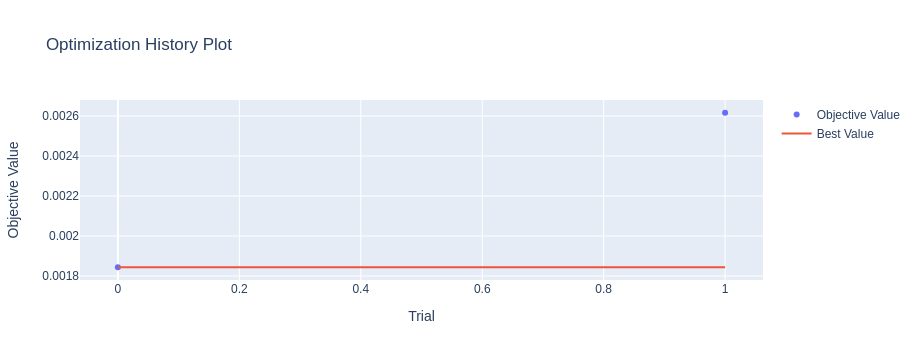

In [22]:
plot_optimization_history(study)

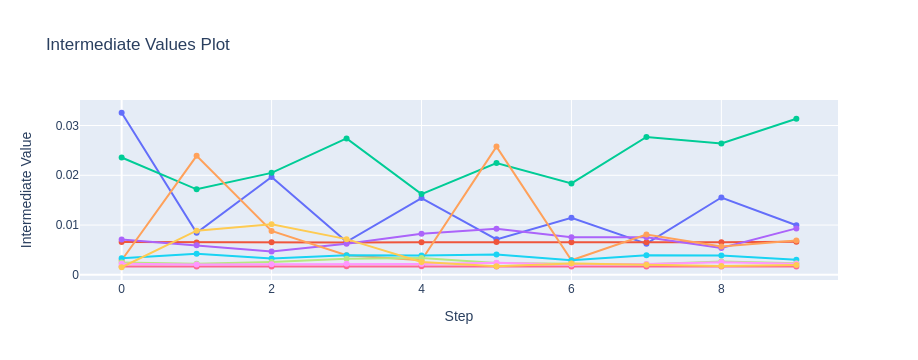

In [16]:
plot_intermediate_values(study)

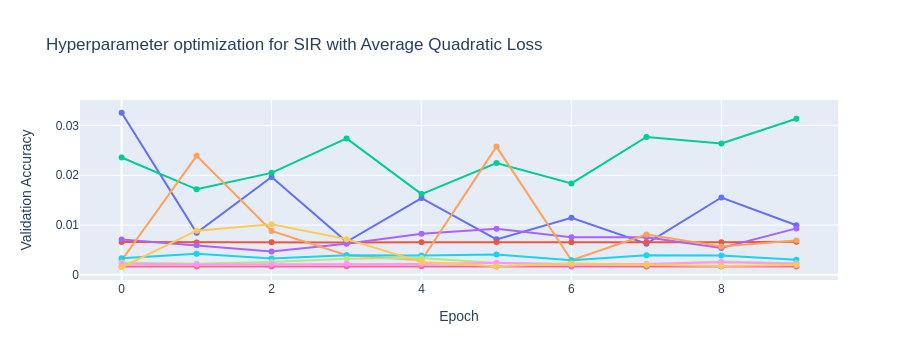

In [19]:
fig = plot_intermediate_values(study)
fig.update_layout(
    title="Hyperparameter optimization for SIR with Average Quadratic Loss",
    xaxis_title="Epoch",
    yaxis_title="Validation Accuracy",
)

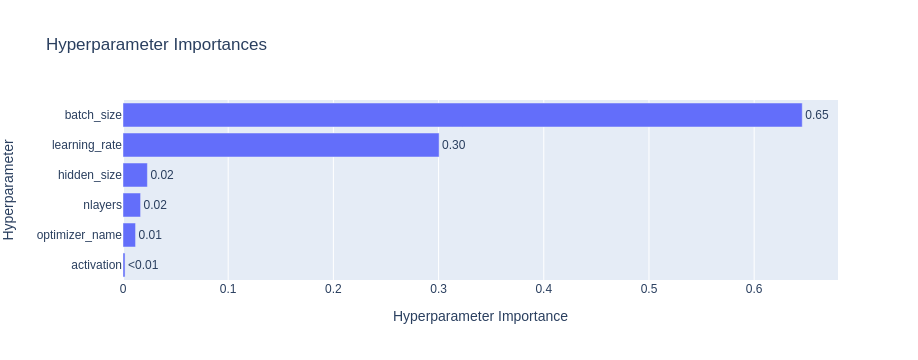

In [17]:
plot_param_importances(study)

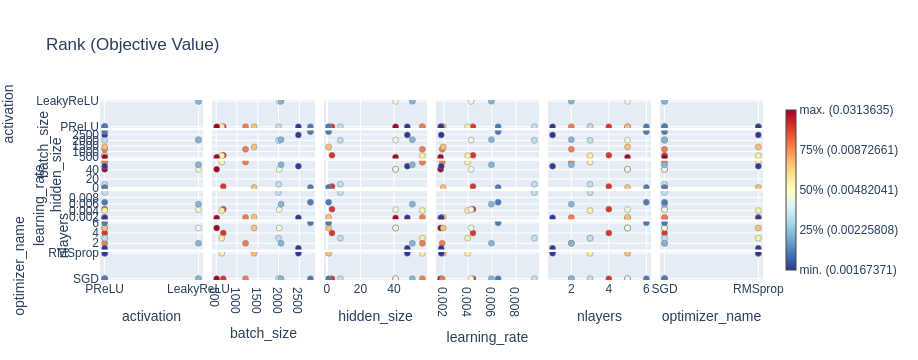

In [18]:
# Visualize parameter relations with scatter plots colored by objective values. See :func:`~optuna.visualization.plot_rank` for the details.
plot_rank(study)

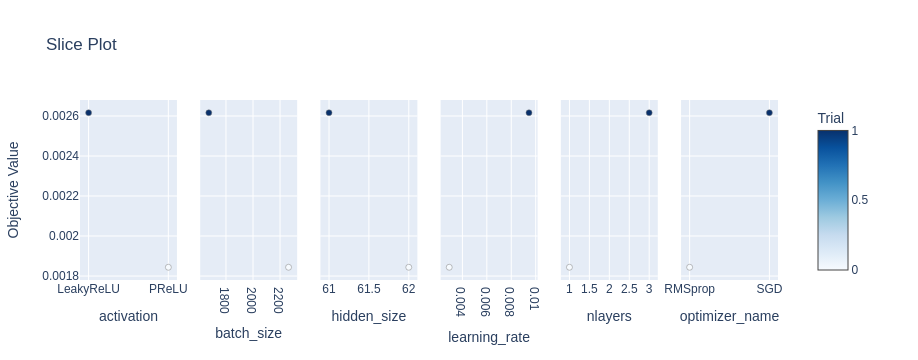

In [23]:
# Visualize individual hyperparameters as slice plot. See :func:`~optuna.visualization.plot_slice` for the details.
plot_slice(study)

## Train new model with optimized hyperparameters for long iterations

In [45]:
def save_model(model, PARAMS, pth_string):
    """pth string is the name of the pth file which is a dictionary of dictionaries"""
    models_path = os.path.join(os.getcwd(), 'SIR_models')
    PATH=os.path.join(models_path, pth_string)
    print(f'saving model with the string : {pth_string}\n')
    torch.save({'PARAMS': PARAMS,
                'model_state_dict': model.state_dict()},
                PATH)
    # print(model)

In [54]:
class SaveModelCheckpoint:
    """Continuous model-checkpointing class. Updates the latest checkpoint of an object based o validation loss each time its called. 
    """
    def __init__(self, best_valid_loss=np.inf):
        """Initiate an instance of the class based on filename and best_valid_loss/

        Args:
            best_valid_loss (float, optional): Best possible validation loss of a checkpoint object. Defaults to np.inf.
        """
        self.best_valid_loss = best_valid_loss

    def __call__(self, model, current_valid_loss, PARAMS, pth_string):
        """When an object of the calss is called, its validation loss gets updated and the model based 
        on the latest validation loss is saved.

        Args:
            model: utils.RegularizedRegressionModel object.
            current_valid_loss (float): current (latest) validation loss of this model during the training process.
            filename_model (str): filename in which the latest model will be saved. Can be a relative or local path. 
        """
        if current_valid_loss < self.best_valid_loss:
            # update the best loss
            self.best_valid_loss = current_valid_loss
            # filename_model='Trained_IQNx4_%s_%sK_iter.dict' % (target, str(int(n_iterations/1000)) )
            # filename_model = "Trained_IQNx4_%s_TUNED_2lin_with_noise.dict" % target

            # note that n_iterations is the total n_iterations, we dont want to save a million files for each iteration
            save_model(model, PARAMS, pth_string)
            print(
                f"\nCurrent valid loss: {current_valid_loss};  saved better model in models/{pth_string}"
            )
            # save using .pth object which if a dictionary of dicionaries, so that I can have PARAMS saved in the same file


In [55]:
def initiate_optimized_model(NTRIALS):
    tuned_dir = 'SIR_models'
    best_params_filename=os.path.join(tuned_dir,'best_params_SIR_avg_quad_loss_%s_trials.csv' % str(int(NTRIALS)))

    BEST_PARAMS = pd.read_csv(best_params_filename)
    print(BEST_PARAMS)

    n_layers = int(BEST_PARAMS["n_layers"]) 
    hidden_size = int(BEST_PARAMS["hidden_size"])

    optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
    learning_rate =  float(BEST_PARAMS["learning_rate"])
    batch_size = int(BEST_PARAMS["batch_size"])
    activation = BEST_PARAMS["activation"].to_string().split()[1]

    optimized_model = SIRModel(
                  nfeatures=train_x.shape[1], 
                    ntargets=1,
                    nlayers=n_layers, 
                    hidden_size=hidden_size,
                    activation=activation
                    )
    print(optimized_model)
    return optimized_model

In [47]:
optimized_model_untrained = initiate_optimized_model(NTRIALS)

   Unnamed: 0  n_layers  hidden_size optimizer_name  learning_rate  \
0           0         3           32            SGD       0.008155   

   batch_size activation  
0        2375  LeakyReLU  
SIRModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.3)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.3)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [56]:
def train_SIR(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window, PARAMS, pth_string):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    model = model.to(device)
    

    train_t, train_x, test_t,  test_x, _, _ = getwholedata_delta_SIR()

    model_checkpoint = SaveModelCheckpoint()
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float().to(device)
            t = torch.from_numpy(batch_t).float().to(device)    


        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, test_x[:n], test_t[:n])
            
            model_checkpoint(model=model, current_valid_loss=acc_v, PARAMS=PARAMS, pth_string=pth_string)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

In [50]:
tuned_dir = 'SIR_models'
best_params_filename=os.path.join(tuned_dir,'best_params_SIR_avg_quad_loss_%s_trials.csv' % str(int(NTRIALS)))

BEST_PARAMS = pd.read_csv(best_params_filename)
BEST_PARAMS

,Unnamed: 0,n_layers,hidden_size,optimizer_name,learning_rate,batch_size,activation
0,0,3,32,SGD,0.008155,2375,LeakyReLU


In [52]:
SIR_Model_AQL_Tuned_PARAMS = {
    "n_layers": int(BEST_PARAMS["n_layers"]) ,
"hidden_size":  int(BEST_PARAMS["hidden_size"]),
# "dropout": float(0.13),
"NFEATURES":int(N_Features),
"activation": BEST_PARAMS["activation"].to_string().split()[1],
'optimizer_name':BEST_PARAMS["optimizer_name"].to_string().split()[1],
'starting_learning_rate':float(BEST_PARAMS["learning_rate"]),
# 'momentum':float(0.9),
'batch_size':int(BEST_PARAMS["batch_size"]),
'n_iterations': int(3e4),
'traces_step':int(1000),
# 'L2':float(0.1),
'pth_string':'SIR_AQL_Tuned_Ntrials_%s.pth' %  str(int(NTRIALS))
}
SIR_Model_AQL_Tuned_PARAMS

{'n_layers': 3,
 'hidden_size': 32,
 'NFEATURES': 3,
 'activation': 'LeakyReLU',
 'optimizer_name': 'SGD',
 'starting_learning_rate': 0.0081546812409542,
 'batch_size': 2375,
 'n_iterations': 30000,
 'traces_step': 1000,
 'pth_string': 'SIR_AQL_Tuned_Ntrials_2.pth'}

In [57]:
optimizer_name=SIR_Model_AQL_Tuned_PARAMS["optimizer_name"]
optimizer_SIR = getattr(torch.optim, str(optimizer_name))(optimized_model_untrained.parameters(), 
                                                           lr=learning_rate)

traces_tuned_SIR = ([], [], [], [])
traces_tuned_SIR = train_SIR(model=optimized_model_untrained,
                             optimizer = optimizer_SIR,
                             avloss=average_quadratic_loss,
                             batch_size=SIR_Model_AQL_Tuned_PARAMS["batch_size"],
                             n_iterations = SIR_Model_AQL_Tuned_PARAMS["n_iterations"],
                             traces = traces_tuned_SIR,
                             step=SIR_Model_AQL_Tuned_PARAMS["traces_step"],
                             window=200,
                             PARAMS=SIR_Model_AQL_Tuned_PARAMS,
                             pth_string=SIR_Model_AQL_Tuned_PARAMS["pth_string"]
                             
                            )   

train_t shape =  (90000,) 

train_x shape =  (90000, 3) 

Iteration vs average loss
 iteration	 train-set	 valid-set
saving model with the string : SIR_AQL_Tuned_Ntrials_2.pth


Current valid loss: 0.5138871073722839;  saved better model in models/SIR_AQL_Tuned_Ntrials_2.pth
         0	  0.513964	  0.513887
saving model with the string : SIR_AQL_Tuned_Ntrials_2.pth


Current valid loss: 0.08276550471782684;  saved better model in models/SIR_AQL_Tuned_Ntrials_2.pth
      1000	  0.082469	  0.082766	  0.082766saving model with the string : SIR_AQL_Tuned_Ntrials_2.pth


Current valid loss: 0.08194046467542648;  saved better model in models/SIR_AQL_Tuned_Ntrials_2.pth
      2000	  0.081649	  0.081940	  0.081940saving model with the string : SIR_AQL_Tuned_Ntrials_2.pth


Current valid loss: 0.08091121912002563;  saved better model in models/SIR_AQL_Tuned_Ntrials_2.pth
      3000	  0.080619	  0.080911	  0.080911saving model with the string : SIR_AQL_Tuned_Ntrials_2.pth


Current valid loss: 0

In [67]:
def load_tuned_model(PARAMS, pth_string):
    models_path = os.path.join(os.getcwd(), 'SIR_models')
    PATH=os.path.join(models_path, pth_string)
    model = SIRModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        activation = PARAMS["activation"]
    )
    checkpoint = torch.load(PATH)
    # print('INITIATED MODEL:',  model)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'loading model with the string : {pth_string}\n')    
    print(model)
    
    return model

In [68]:
SIR_Tuned_Model_AQL = load_tuned_model(SIR_Model_AQL_Tuned_PARAMS, 
                                 SIR_Model_AQL_Tuned_PARAMS['pth_string'])

loading model with the string : SIR_AQL_Tuned_Ntrials_2.pth

SIRModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.3)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.3)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
